# Data Preprocessing
> gathering data and creating a dataset

[WSISEG-Database](https://github.com/CV-Application/WSISEG-Database) is a public dataset hosted on github that contains 400 sky imager pictures. 

The database contains 400 uncropped whole sky images and corresponding labels. The label images are: cloud, clear sky and backgound area are marked with gray value 255, 100, 0 respectively.

You can find the original [paper](https://www.atmos-meas-tech.net/13/1953/2020/amt-13-1953-2020.pdf) that introduces the dataset.

We will:
- Download the dataset
- Clean and fix issues with the data
- Upload an initial version to `wandb`. We will make the code functional so we can reuse this on another task/dataset.
- Perform some operations on the dataset (split/resize) and re-upload the new version.

##  Get the data
> We will first download the dataset

When you get a new dataset, usually it is not perfect. It needs some fixing before we can use it to train a model.

In [1]:
import shutil
from fastcore.all import *

In [2]:
def download_wsiseg(dest_path, force=False):
    "Download WSISEG dataset at dest, force to overwrite"
    dest_path = Path(dest_path)
    if dest_path.exists(): 
        if force:
            shutil.rmtree(dest_path)
        else:
            return
    if not dest_path.exists():
        print(f'Cloning repo WSISEG into {dest_path}')
        code = run(f'git clone https://github.com/CV-Application/WSISEG-Database {dest_path}')

In [3]:
PATH = Path.cwd() 
DATASET_PATH = PATH / 'WSISEG-Database'
download_wsiseg(DATASET_PATH, force=True)

Cloning repo WSISEG into /home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database


In [4]:
list(DATASET_PATH.iterdir())

[Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/.git'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/README.md'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/annotation'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/whole sky images')]

## wandb init and setup

Let's start a run

In [5]:
# %pip install wandb -Uqq

In [6]:
import wandb

PROJECT_NAME = "cloud_segmentation"

it is a good idea to give a `project` name and a `job_type` so we get labels on the dashboard.

## 🚀 Let's log our first version of the dataset:
> We will upload the folder entirely, this is a simple but straightforward way of putting your data in wandb.

In [7]:
def not_hidden(path):
    "check if file/folder is not hidden"
    return not path.name.startswith('.')

In [8]:
@delegates(wandb.Artifact)
def upload_folder(folder_path: PATH, name, type='dataset', **kwargs):
    "Upload a version of the dataset"
    artifact_dataset = wandb.Artifact(name=name, type=type, **kwargs)
    
    #upload folders and files insidet `dataset_path`
    for f in folder_path.iterdir():
        if not_hidden(f):
            if f.is_dir():
                artifact_dataset.add_dir(f, name=f.name)
            else:
                artifact_dataset.add_file(f)
            
    #we return a use_artifact so we can pipe in this on the next step.
    return wandb.log_artifact(artifact_dataset)

In [9]:
JOB_TYPE  = "load-data"

with wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE) as run:
    artifact_dataset = upload_folder(DATASET_PATH, 'WSISEG-Database', 
                                     description='Raw WSISEG dataset', 
                                     metadata={"source": 'https://github.com/CV-Application/WSISEG-Database'})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tcapelle (use `wandb login --relogin` to force relogin)


wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/annotation)... Done. 0.1s
wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/whole sky images)... Done. 0.1s


After doing this, we get the object uploaded as an `Artifact`, and can be found on the `Artifacts` tab on the run:

![](images/files.png)

and to look at the actual images, you have to fo to `Files`

![](images/files_images.png)

this is not very practical if one wants to inspect the dataset in a visual way.

## Fixed version

this dataset is pretty flawed (as always), we will fix some thing and re-upload a fixed version to `wandb`.
- folder names with spaces is almost never desired
- If you look inside the folders, the images have no extension.

let's fix this:

In [10]:
def fix_dataset(path, image_folder_name='images', masks_folder_name='masks'):
    
    "Fix dataset filenames"
    
    if (path/'whole sky images').exists() and (path/'annotation').exists():
        image_path = (path/'whole sky images').rename(path/image_folder_name)
        annotation_path = (path/'annotation').rename(path/masks_folder_name)
        print(f'Rename folders to: {image_path}, {annotation_path}')
        
        for folder in [image_path, annotation_path]:
            for im in folder.iterdir():
                if not im.name.endswith('.png'):
                    im.rename(im.with_suffix('.png'))
        print('Fixing image extentions -> .png')
        
    if (path/'.git').exists():
        shutil.rmtree(path/'.git')
        print('delete .git folder')

In [11]:
fix_dataset(DATASET_PATH)

Rename folders to: /home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images, /home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/masks
Fixing image extentions -> .png
delete .git folder


In [12]:
JOB_TYPE  = "fix-data"

with wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE) as run:

    # ✔️ declare which artifact we'll be using
    _ = run.use_artifact('WSISEG-Database:latest')
    
    artifact_dataset = upload_folder(DATASET_PATH, 
                                     name='WSISEG-Database-fixed', 
                                     description='Fixed WSISEG dataset, image -> mask folders', 
                                     metadata={"source": 'https://github.com/CV-Application/WSISEG-Database'})

wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/masks)... Done. 0.1s
wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images)... Done. 0.1s


## A more visual way
> Let's look at our data

In [13]:
image_path = DATASET_PATH/f'images'
mask_path  = DATASET_PATH/f'masks'

In [14]:
files = list(image_path.iterdir())
files[0:5]

[Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images/ASC100-1006_013.png'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images/ASC100-1006_001.png'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images/ASC100-1006_048.png'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images/ASC100-1006_026.png'),
 Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images/ASC100-1006_184.png')]

We will grab some image functionalities from `fastai.vision`, to make us easier to show images side by side.

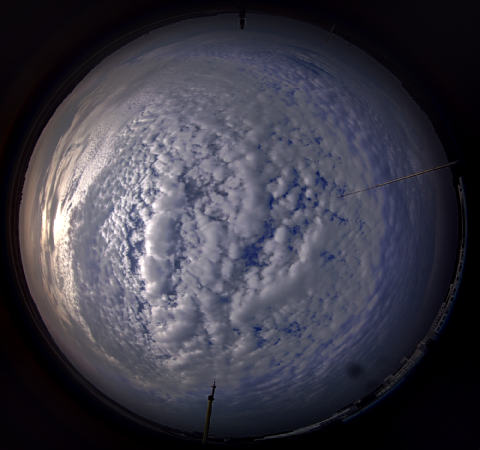

In [15]:
import math
import matplotlib.pyplot as plt
from PIL import Image

def load_image(fn, mode=None):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im


im = load_image(files[0])
im

In [16]:
im.size

(480, 450)

In [17]:
list(mask_path.iterdir())[0]

Path('/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/masks/ASC100-1006_013.png')

The masks are called identically but place on the respective `masks` folder

In [18]:
def get_mask_name(fname): 
    "Get the mask filename from the image name"
    folder = fname.parent.name.replace('images', 'masks')
    return (fname.parent.parent/folder)/fname.name

In [23]:
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL image on `ax`."
    if figsize is None: 
        figsize = (6,6)
    if ax is None: 
        _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: 
        ax.set_title(title)
    ax.axis('off')
    return ax

<AxesSubplot:>

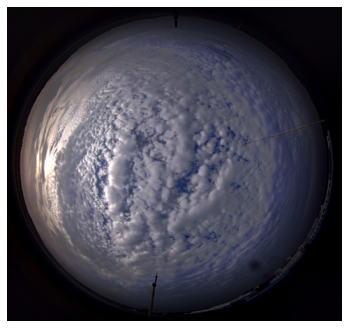

In [24]:
show_image(im)

In [25]:
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: 
        ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: 
        titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

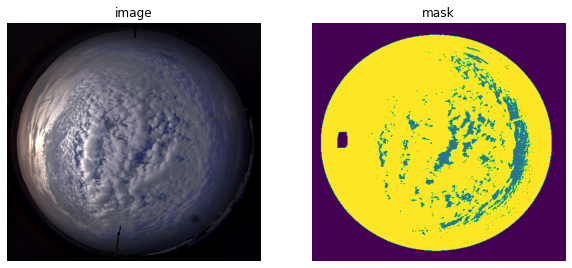

In [26]:
mask = load_image(get_mask_name(files[0]))
show_images([im, mask], figsize=(10,5), titles=['image', 'mask'])

As a user, we would like to have this type of plotting on the dashboard, so we can look at inputs/labels pairs.

## Uploading as a `wandb.Table`

We want to construct a Table that contains image pairs `(RGBImage, Mask)`. To do so, let's create a class that inherits from `wandb.Table`:

In [37]:
#export
class ImageTable(wandb.Table):
    """A basic Table containing images.
    Args:
    - image_paths List[Path]: A list of paths referencing images.
    - label_func  Callable: A function to label images.
    """
    _show_rows=4
    @classmethod
    def from_files(cls, image_paths, label_func):
        image_table = cls(columns=['img', 'label'])
        for img_path in image_paths:
            image_table.add_data(wandb.Image(str(img_path)), label_func(img_path))    
        return image_table
    
    @classmethod
    def from_folder(cls, folder_path, label_func):
        files = Path(folder_path).ls()
        # we could put `get_image_files` here from fastai
        return cls.from_files(files, label_func)
    
    @classmethod
    def from_csv(cls, csv_file_name):
        image_table = cls(columns=['img', 'label'])
        with open(csv_file_name) as csvfile:
            csv_reader = csv.reader(csvfile, delimiter=',')
            for (img_path, mask_path) in csv_reader:
                image_table.add_data(wandb.Image(str(img_path)), wandb.Image(str(mask_path)))    
        return image_table
    
    def log_to_workspace(self, name='table'):
        wandb.log({name: self})
    
    @delegates(wandb.Artifact, but='name, type')
    def log_to_artifact(self, name, type, tag=None, **kwargs):
        artifact = wandb.Artifact(name=name, type=type, **kwargs)
        artifact["data"] = self
        
        if tag is not None:
            wandb.log_artifact(artifact, aliases=[tag, "latest"])
        else:
            wandb.log_artifact(artifact)     
            
        # log Table to the workspace for easier visualization
        self.log_to_workspace()
                
#     def __repr__(self):
#         return f'ImageTable(rows={len(self.data)}, cols={len(self.data[0])})'
    
    def show_batch(self, n=4):
        for row in self.data[:n]:
            show_images([col.image for col in row if isinstance(col, wandb.Image)])

In [28]:
def label_func(path):
    "get mask as a wandb.Image type"
    return wandb.Image(str(get_mask_name(path)))

table = ImageTable.from_folder(image_path, label_func=label_func)

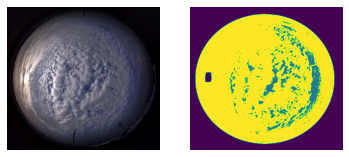

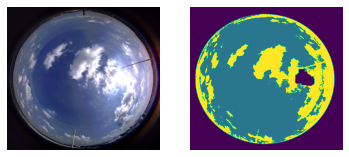

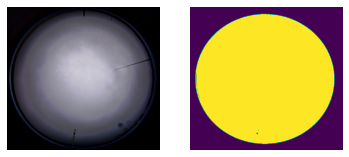

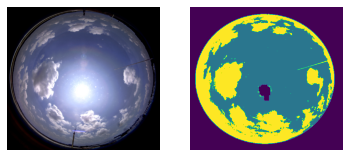

In [29]:
table.show_batch()

we get a nice table with pairs of `wandb.Image` objects

In [32]:
JOB_TYPE  = "upload-table"

with wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE) as run:
    _ = run.use_artifact('WSISEG-Database-fixed:latest')
    table.log_to_artifact('WSISEG_table', type='dataset')

and now we get a nicely formated dataset in the form of a Table, we can even see it on the workspace:

![](images/table1.png)

and you can also find the table in the corresponding Artifact, under the `data` keyword that we used to store the table inside the artifact.

![](images/table2.png)

## Bonus
> Could we make a pandas dataframe that has an image column?

In [104]:
import pandas as pd
from IPython.core.display import display,HTML

df = pd.DataFrame([['A231', 'Book', 5, 3, 150], 
                   ['M441', 'Magic Staff', 10, 7, 200]],
                   columns = ['Code', 'Name', 'Price', 'Net', 'Sales'])

# your images
images1 = ['https://vignette.wikia.nocookie.net/2007scape/images/7/7a/Mage%27s_book_detail.png/revision/latest?cb=20180310083825',
          'https://i.pinimg.com/originals/d9/5c/9b/d95c9ba809aa9dd4cb519a225af40f2b.png'] 


images2 = ['https://static3.srcdn.com/wordpress/wp-content/uploads/2020/07/Quidditch.jpg?q=50&fit=crop&w=960&h=500&dpr=1.5',
           'https://specials-images.forbesimg.com/imageserve/5e160edc9318b800069388e8/960x0.jpg?fit=scale']

df['imageUrls'] = images1
df['otherImageUrls'] = images2


# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', None)

image_cols = ['imageUrls', 'otherImageUrls']  #<- define which columns will be used to convert to html

# Create the dictionariy to be passed as formatters
format_dict = {}
for image_col in image_cols:
    format_dict[image_col] = path_to_image_html


display(HTML(df.to_html(escape=False ,formatters=format_dict)))

,Code,Name,Price,Net,Sales,imageUrls,otherImageUrls
0,A231,Book,5,3,150,,
1,M441,Magic Staff,10,7,200,,


In [42]:
image_path.ls()

(#400) [Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_013.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_001.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_048.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_026.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_184.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_079.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_386.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_149.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_332.png'),Path('/home/tcapelle/WANDB/cloud_segmentation/WSISEG-Database/images/ASC100-1006_156.png')...]

In [43]:
pd.set_option('display.max_colwidth', None)

In [91]:
def path_to_image_html(path):
    path = path.relative_to(Path.cwd().parent)
    return '<img src = "../'+ str(path) + '" width="60" >'

In [92]:
len(image_path.ls())

400

In [93]:
image_paths = image_path.ls()[0:5]
mask_paths  = [get_mask_name(p) for p in image_path.ls()[0:5]]

assert len(image_paths) == len(mask_paths)

In [94]:
image_paths[0].relative_to('/home/tcapelle/WANDB/cloud_segmentation')

Path('WSISEG-Database/images/ASC100-1006_013.png')

In [95]:
df = pd.DataFrame()

In [96]:
df['image'] = image_paths
df['mask']  = mask_paths

In [97]:
html_df = df.to_html(escape=False, formatters=dict(image=path_to_image_html, mask=path_to_image_html))

In [99]:
html_df

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>image</th>\n      <th>mask</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td><img src = "../WSISEG-Database/images/ASC100-1006_013.png" width="60" ></td>\n      <td><img src = "../WSISEG-Database/masks/ASC100-1006_013.png" width="60" ></td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td><img src = "../WSISEG-Database/images/ASC100-1006_001.png" width="60" ></td>\n      <td><img src = "../WSISEG-Database/masks/ASC100-1006_001.png" width="60" ></td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td><img src = "../WSISEG-Database/images/ASC100-1006_048.png" width="60" ></td>\n      <td><img src = "../WSISEG-Database/masks/ASC100-1006_048.png" width="60" ></td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td><img src = "../WSISEG-Database/images/ASC100-1006_026.png" width="60" ></td>\n      <td><img src = "../WSISEG-Database/masks/ASC100-1006_02

In [98]:
display(HTML(html_df))

,image,mask
0,,
1,,
2,,
3,,
4,,


## Split
> Let's split the dataset on train/valid

We will use the first 340 images as training and the last 60 as validation. We will save a `csv` file with this split. We could actually move then and create a folder hierarchy `train/images/...` and `valid/images/...`.

In [33]:
n_train = 340

In [35]:
import csv

def write_split_csv(img_paths, csv_fname):
    with open(csv_fname, 'w') as f:
        data = csv.writer(f)
        for img_path in img_paths:
            row = [str(img_path.relative_to(Path.cwd())), str(get_mask_name(img_path).relative_to(Path.cwd()))]
            data.writerow(row)

write_split_csv(files[0:n_train], DATASET_PATH/'train.csv')
write_split_csv(files[n_train:],  DATASET_PATH/'valid.csv')

In [39]:
table = ImageTable.from_csv(DATASET_PATH/'train.csv')

In [41]:
JOB_TYPE  = "split-data"

with wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE) as run:

    # ✔️ declare which artifact we'll be using
    _ = run.use_artifact('WSISEG-Database-fixed:latest')
    
    artifact_dataset = upload_folder(DATASET_PATH, 
                                     name='WSISEG-Database-splited', 
                                     description='Fixed WSISEG dataset, image -> mask folders, with splits', 
                                     metadata={"source": 'https://github.com/CV-Application/WSISEG-Database'})
    
    for name in ['train', 'valid']:
        table = ImageTable.from_csv(DATASET_PATH/(name+'.csv'))
        table.log_to_artifact('WSISEG_table_'+name, type='dataset')

wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/masks)... Done. 0.1s
wandb: Adding directory to artifact (/home/tcapelle/WANDB/cloud_segmentation/notebooks/WSISEG-Database/images)... Done. 0.1s


## Pytorch Dataset

In [44]:
table.__str__

<method-wrapper '__str__' of ImageTable object at 0x7fcbe355fa60>

In [ ]:
class Dataset(wandb.Artifact):
    
    

In [106]:
JOB_TYPE  = "create-dataset"

run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE)
at = run.use_artifact('WSISEG-Database-splited:latest')

In [109]:
at["data"]

# Train a model